## Self-supervised learning

### Why self-supervised learning in robotics
Normally, when thinking of 'learning robots', one thinks of reinforcement learning or imitation learning - both learning settings in which robots attempt to directly learn better control policies. A more recent form of learning, which typically involves the learning of perceptual abilities, is _self-supervised learning_ (SSL). 

A self-supervised learning robot provides its own supervised learning targets. This seems strange at first: Why would a robot want to learn what it already knows?

The best example to illustrate why SSL is useful, is perhaps also the most famous and one of the first robots to use SSL: The robot 'Stanley' used SSL to win the DARPA Grand Challenge in 2005 [1]. In that challenge, autonomously driving cars had to drive a 212 km long, off-road course, as fast as possible. Stanley's programs consisted of a lot of impressive elements, but one of the most important and interesting ones was the use of SSL for looking further ahead. The SSL scheme was set up as follows: Stanley could use its LiDAR measurements to reliably detect whether the ground ahead consisted of drivable terrain (road) or not. However, the range of the LiDAR measurements was limited. In contrast to the LiDAR, Stanley's cameras could see the ground and terrain also at very large ranges. This led to the following learning setup: at the close distances, LiDAR provided supervised training for a vision algorithm that learned a mapping from visual appearance (color, texture) to terrain labels (drivable / non-drivable). Then, the vision algorithm could be applied to areas higher up in the image, beyond the LiDAR range. 

This self-supervised learning setup allowed Stanley to detect the road further ahead, speed up, and win the race (by 11 minutes on the 212km track!).

<IMG SRC="Stanley2.JPG" WIDTH="50%" ALT="An official DARPA photograph of Stanley at the 2005 DARPA Grand Challenge. Stanley, created by the Stanford University Racing Team, won the race and the 2 million US dollar prize. This photograph was found at http://www.darpa.mil/grandchallenge05/high_res"></IMG>
<CENTER>*Figure 1:* The robot 'Stanley' that won the 2005 DARPA Grand Challenge, partially thanks to self-supervised learning. </CENTER>

Another way of self-supervised learning generates the targets from input data. For instance, in [2] an algorithm was proposed that allows to learn monocular depth estimation based on stereo vision images. The idea is illustrated in Figure 2 below. A deep neural network maps a single image (the left image from the stereo pair) to a depth map. The known geometry from the stereo vision setup, allows the algorithm to warp the left image with the depth map to the expected right image. The expected right image is compared to the actual right image, with the difference between these images termed the reconstruction error. This reconstruction error can be backpropagated to first obtain errors for the depth map and then for the weights in the deep neural network, allowing to adjust the weights so that the reconstruction error is minimal. In this way, the algorithm is able to learn monocular depth estimation without any human or other supervision. After [2], many other studies have elaborated on this core idea, and now self-supervised learning is the main way of learning monocular depth estimation.

<IMG SRC="idea_SSL_depth.png" WIDTH="80%" ALT="Idea behind Garg's monocular depth estimation algorithm. Open access image from https://github.com/Ravi-Garg/Unsupervised_Depth_Estimation/blob/master/idea.png"></IMG>
<CENTER>*Figure 2:* The idea behind self-supervised learning of monocular depth estimation. </CENTER>

### Definition of self-supervised learning
Supervised learning is one of the major problem settings within machine learning. 

*Definition:* _"Supervised learning is the machine learning task of learning a function that maps an input to an output based on example input-output pairs."_ (From <A HREF="https://en.wikipedia.org/wiki/Supervised_learning" TARGET="_blank">Wikipedia</A>)

_Self-supervised learning_ (SSL) is a newer, less known form of machine learning and hence its definition is also less established. In fact, SSL is a subset of supervised learning, which sets a restriction on how the example input-output pairs are obtained. That is, these example pairs are not determined by a human, but are self-generated.

*Definition:* _"Self-supervised learning is a type of supervised learning where the training labels are determined by the input data."_ (From <A HREF="https://machinelearning.wtf/terms/self-supervised-learning/" TARGET="_blank">Machine Learning Glossary</A>)

From a robotics stand point, the defition could be:

*Definition:* _"Self-supervised learning is a type of supervised learning where the training labels are generated by the robot itself."_ 

From a machine learning stand point, self-supervised learning is equal to supervised learning. This means that the methods and principles for supervised are also applicable to self-supervised learning. Hence, one can wonder whether it is useful to make a distinction between supervised learning and SSL. 

The main property of SSL is that the self-supervised setup allows for the generation of large numbers of training examples, without any human effort. This is a huge advantage for deep learning methods, which perform much better when ample training data is available. Of course, the automated generation of training examples has consequences on the problem setting. For example, in a robotic scenario, training examples will come continuously from the robot's sensors. This means that these examples are typically statistically dependent on each other. This goes in against the typical assumption of _independent, identically distributed_ (i.i.d.) samples. Moreover, training examples are not verified by a human, so the training set could contain more wrong examples or more noise than in a typical, human-made training set.

## Case study: learning to estimate height
In this notebook, you will study a very simple case of self-supervised learning, introduced in [3]. A drone has two sensors that are supposed to capture height: a sonar and a barometer. Normally, one would convert the measured pressure to meters, using the pressure at startup for a 0-meter calibration. Then, one would characterize both sensors in terms of how accurate they are, and fuse the measurements to obtain a height estimate. 

However, in this SSL case study, we will assume that we only know of the sonar what its relation is to height in meters. We will then try to learn to predict the sonar measurements by means of pressure measurements. After learning, the drone can also use the barometer for height estimation. What is special about this case study is that, in contrast to most work on SSL, we will fuse the height estimate from the barometer back with the sonar measurement and see whether the fused estimate is better than sonar alone. In order to determine which is better, we compare the fused estimates with highly accurate motion tracking system estimates (in our case Optitrack). The overview of the learning setup is shown in Figure 3.

<IMG SRC="overview_fusion.png" WIDTH="70%"></IMG>

<FONT COLOR="red">Exercise 1.</FONT>

1. Run the cell below to have a look at the data. It imports the Python file <A HREF="SSL_drone_data.py" TARGET="_blank">SSL_drone_data.py</A>, loads and plots the data. The first plot shows $h_{\textrm{sonar}}$, $h_{\textrm{pressure}}$, and $h_{\textrm{Optitrack}}$. To obtain $h_{\textrm{pressure}}$, we make use of the formula that relates pressure to height (<A HREF="https://en.wikipedia.org/wiki/Barometric_formula" TARGET="_blank">Wikipedia</A>). Please make your own code to map the pressure measurement to height. Compare it with the height from Optitrack. What is the main problem in mapping pressure to height?


Text(0, 0.5, 'Pressure [Pa]')

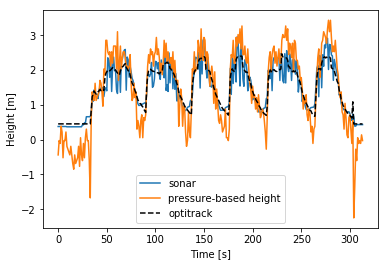

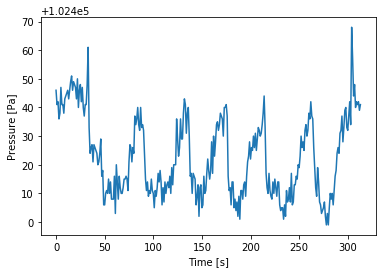

In [3]:
%matplotlib inline
from matplotlib import pyplot as plt
import SSL_drone_data as SSL

# drone_data is a dict with the following keys:
# 'pressure', 'sonar', and 'optitrack'
drone_data = SSL.get_drone_data()
SSL.plot_drone_data(drone_data)

# plot the pressure
plt.figure()
plt.plot(drone_data['pressure'])
plt.xlabel('Time [s]')
plt.ylabel('Pressure [Pa]')

## References
[1] Thrun, S., Montemerlo, M., Dahlkamp, H., Stavens, D., Aron, A., Diebel, J., ... & Lau, K. (2006). Stanley: The robot that won the DARPA Grand Challenge. Journal of field Robotics, 23(9), 661-692.

[2] Garg, R., BG, V. K., Carneiro, G., & Reid, I. (2016, October). Unsupervised cnn for single view depth estimation: Geometry to the rescue. In European Conference on Computer Vision (pp. 740-756). Springer, Cham.

[3] de Croon, G. C. H. E. (2017). Self-supervised learning: When is fusion of the primary and secondary sensor cue useful?. arXiv preprint arXiv:1709.08126.